In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from rodent_loss_src.rnaseq import reads_per_gene_in_condition


ORGANISMS = ["human", "mouse"]
MIRNAS = ["mir197", "mir769"]
OUTDIR = '/home/felixl/PycharmProjects/rodent_loss/analyses/down_and_predicted/results/read_heatmap'

def read_and_filter_predicted_targets(path, organism, mirna, targetscan_cutoff=-0.2):
    """
    Returns significantly down-regulated genes specific to one miRNA and one organism. Only takes **TargetScanHuman** results into account!
    """
    df = pd.read_csv(path, sep='\t')
    df.mirna = df.mirna.apply(lambda x: x.replace('Mir-197-3p', 'mir197').replace('Mir-769-5p', 'mir769'))
    
    df = df[df['organism']  == organism]
    df = df[df['mirna'] == mirna]
    df = df.filter(['gene', 'TShuman_tc++s'])
    df = df[(df['TShuman_tc++s'] <= targetscan_cutoff)]
    if organism == 'mouse':
        df['gene'] = df['gene'].str.capitalize()

    # modify index
    df = df.set_index('gene')

    return df

def zscore_targetscan_heatmap(df, cmap='viridis'):
    sns.set(rc={'figure.figsize':(2.5,6)})
    sns.set(font_scale=0.8)
    tardf = df.filter(['TShuman_tc++s'])
    expdf = df.drop(columns=['TShuman_tc++s'])
    zdf = expdf.apply(zscore, axis=1)
    
    fig, (ax,ax2) = plt.subplots(ncols=2)
    sns.heatmap(tardf, cmap=cmap, ax=ax, vmin=-1, vmax=-0.2, linewidth=0.3)
    sns.heatmap(zdf, cmap="vlag", ax=ax2, vmin=-1, vmax=1.5, linewidth=0.3)

    ax2.yaxis.tick_right()
    ax2.tick_params(rotation=0)
    return fig


def filter_readsdf_mirna(df, mirna):
    df = df.rename(columns=lambda col: col.replace('Neg-Ctl', 'CTRL'))
    if mirna == 'mir197':
        columns = [col for col in df.columns if not '-769_' in col]
    else:
        columns = [col for col in df.columns if not '-197_' in col]
    return df.filter(columns)


tarpath = '/home/felixl/PycharmProjects/rodent_loss/milestones/data/targetscan/sigdown_and_predictedTargets_tsM_tsH.tsv'
# for organism in ORGANISMS:
#     countpath = f'/home/felixl/PycharmProjects/rodent_loss/external_data/counts_matrix/{organism}_counts.matrix'
#     reads_df = reads_per_gene_in_condition(countpath)
#     for mirna in MIRNAS:
#         mir_reads_df = filter_readsdf_mirna(reads_df, mirna)
#         targetdf = read_and_filter_predicted_targets(tarpath, organism, mirna)

#         heat_df = mir_reads_df.join(targetdf, how='inner')
#         heat_df = heat_df.sort_values(['TShuman_tc++s'])
#         fig = zscore_targetscan_heatmap(heat_df)
#         plt.savefig(f'{OUTDIR}/{organism}_{mirna}_read_heatmap.svg')


## Heatmap per gene for both organisms

In [2]:
tarpath = '/home/felixl/PycharmProjects/rodent_loss/milestones/data/targetscan/sigdown_and_predictedTargets_tsM_tsH.tsv'
countpath = '/home/felixl/PycharmProjects/rodent_loss/external_data/counts_matrix/{}_counts.matrix'

def doapr_long_overview(tarpath, countpath):
    col = []
    all_genes_of_interest = set()
    for organism in ORGANISMS:
        # print(organism)
        reads_df = reads_per_gene_in_condition(countpath.format(organism))
        for mirna in MIRNAS:
            mir_reads_df = filter_readsdf_mirna(reads_df, mirna)
            # display(mir_reads_df)
            targetdf = read_and_filter_predicted_targets(tarpath, organism, mirna)
            heat_df = mir_reads_df.join(targetdf, how='inner')
            heat_df = heat_df.sort_values(['TShuman_tc++s'])
            for gene in heat_df.index.values:
                col.append([gene, gene.upper(), mirna, organism])
            all_genes_of_interest.update(heat_df.index.values)
            all_genes_of_interest.update([gene.upper() for gene in heat_df.index.values])
            all_genes_of_interest.update([gene.capitalize() for gene in heat_df.index.values])
    df = pd.DataFrame(col, columns=['name', 'upper_name', 'mirna', 'organism'])
    return df, all_genes_of_interest

doapr_df, all_genes_of_interest = doapr_long_overview(tarpath, countpath)
display(doapr_df)

,name,upper_name,mirna,organism
0,PGPEP1,PGPEP1,mir197,human
1,TTPAL,TTPAL,mir197,human
2,MPZL1,MPZL1,mir197,human
3,INPP5A,INPP5A,mir197,human
4,PLD1,PLD1,mir197,human
...,...,...,...,...
80,Fut11,FUT11,mir769,mouse
81,Tbc1d2,TBC1D2,mir769,mouse
82,Ipmk,IPMK,mir769,mouse
83,Usb1,USB1,mir769,mouse


In [3]:
def merge_human_mouse_readtables(countpath, all_genes_of_interest):
    """

    """
    col = []
    for organism in ORGANISMS:
        reads_df = reads_per_gene_in_condition(countpath.format(organism))
        # filter for genes that are significantly down-regulated and predicted as targets in at least one condition
        fildf = reads_df[reads_df.index.isin(all_genes_of_interest)]
        # add information in which organism data was collected
        fildf = fildf.rename(columns=lambda col: f'{organism}_{col}')
        # convert mouse gene names for joining tables
        fildf.index = fildf.index.str.upper()
        # calculate Zscore
        fildf = fildf.apply(zscore, axis=1, nan_policy='propagate')
        col.append(fildf)
    df = col[0].join(col[1], how='outer')
    return df


zdf = merge_human_mouse_readtables(countpath, all_genes_of_interest)
display(zdf)

,human_Neg-Ctl_1,human_Neg-Ctl_2,human_Neg-Ctl_3,human_miR-197_1,human_miR-197_2,human_miR-197_3,human_miR-769_1,human_miR-769_2,human_miR-769_3,mouse_CTRL_1,mouse_CTRL_2,mouse_CTRL_3,mouse_CTRL_4,mouse_miR-197_1,mouse_miR-197_2,mouse_miR-197_3,mouse_miR-197_4,mouse_miR-769_1,mouse_miR-769_2,mouse_miR-769_3
name,,,,,,,,,,,,,,,,,,,,
ABHD17C,0.613005,1.537828,0.900019,-0.662612,-1.842559,-0.917736,0.804348,-0.088585,-0.343708,-1.242436,-0.385285,-0.194807,0.376627,-1.194816,-1.242436,0.233768,-0.099568,1.709973,1.757592,0.281388
AK4,-0.243109,-0.256172,-0.197390,1.637903,1.363588,0.873742,-0.830925,-0.968082,-1.379554,1.110286,1.160795,1.231508,1.504258,-0.970697,-1.213141,-1.102021,-0.829271,-0.202956,-0.192854,-0.495909
AKAP5,0.497650,1.531230,1.221156,-1.156079,-1.569511,-0.949363,-0.019140,-0.019140,0.463197,0.311347,-0.153035,2.575207,-1.197893,0.311347,-0.559369,0.311347,-0.733512,-0.327178,-1.139846,0.601585
APPL2,1.687419,1.328676,0.431820,-0.943360,-1.062941,-0.823779,0.491610,-1.122732,0.013287,0.145655,0.320896,0.946756,0.170689,0.846619,0.120620,1.272204,0.746481,-1.756961,-1.406479,-1.406479
ARHGAP10,0.656902,1.109195,0.398449,0.608442,0.349989,0.996122,-1.523797,-1.346111,-1.249191,-0.258137,-0.428507,1.615937,-0.201347,0.764085,0.309764,0.593715,-1.848261,0.877666,-1.677890,0.252974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USB1,0.351909,0.045408,0.300826,-1.231683,-1.895770,-0.414345,0.607327,1.680083,0.556244,0.863669,0.968646,0.548740,1.283575,0.128835,-0.028630,0.233811,0.496252,-1.445811,-1.130882,-1.918204
VAMP3,0.474640,1.473233,-0.024657,0.030821,-2.188275,-1.023250,0.308208,0.807504,0.141776,0.499691,0.823020,0.966722,1.415790,-1.188806,-1.296583,-1.296583,-1.260657,0.194324,0.769132,0.373951
VPS36,-0.730417,-0.212485,-0.292167,-0.889781,-0.810099,-0.969463,1.341312,1.938926,0.624175,0.056235,0.000000,0.281175,0.393645,1.000983,1.372134,0.708561,0.708561,-1.698297,-1.462110,-1.360887


**ToDo: Check what's going on with NaN values**

**ToDo: Z-score for each miRNA independently**


## Check NaN values

In [4]:
nans = zdf[zdf.isnull().any(axis=1)]
display(doapr_df[doapr_df.upper_name.isin(nans.index)])

,name,upper_name,mirna,organism
24,HTR7,HTR7,mir769,human
29,DSC3,DSC3,mir769,human
35,RAB39A,RAB39A,mir769,human


## Plot heatmap

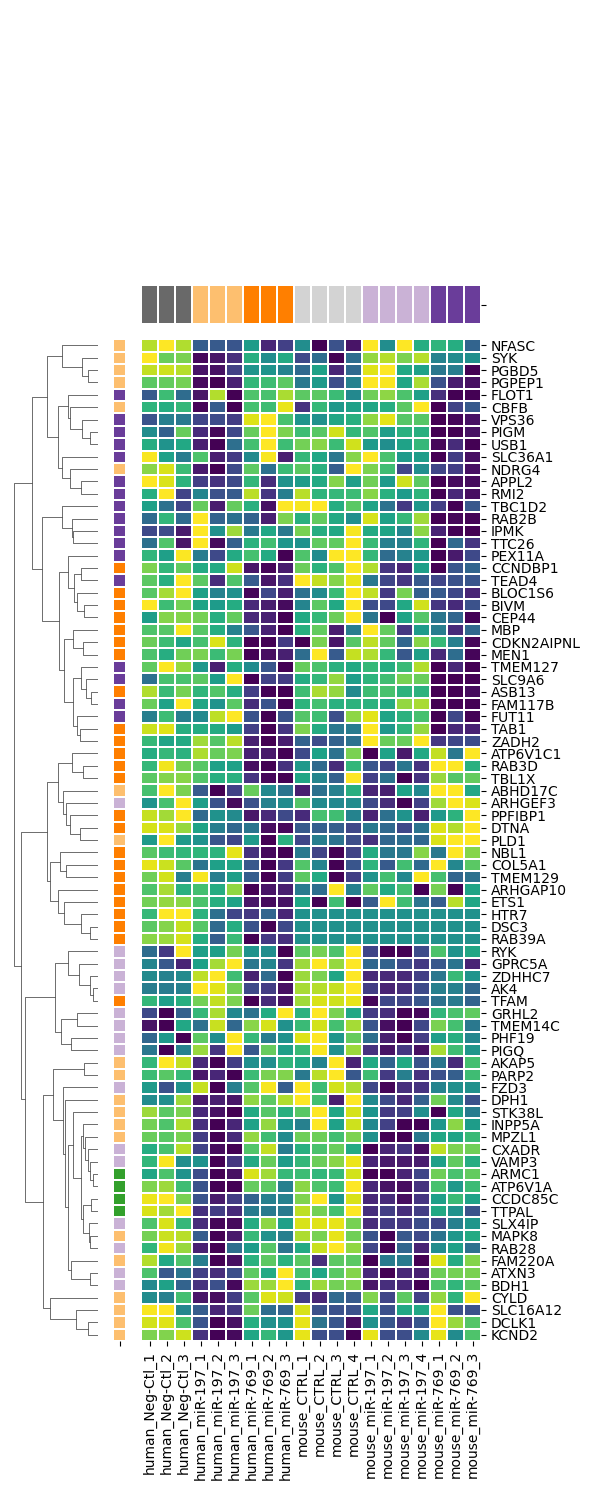

In [8]:
import numpy as np

palette = sns.color_palette("Paired")
category_to_color = {
    'human|mir197': palette[6],  # light orange
    'human|mir769': palette[7],  # dark orange
    'mouse|mir197': palette[8],  # light purple
    'mouse|mir769': palette[9],  # dark purple
    'human|mouse|mir197' : palette[3],  # green
    'human|control': 'dimgrey',
    'mouse|control': 'lightgrey',
}

def map_gene_to_color(df, category_to_color):
    multiple = set()
    gene2color = {}
    for i, row in df.iterrows():
        name, upper_name, mirna, organism = row
        if upper_name in gene2color:
            multiple.add(upper_name)
            gene2color[upper_name] = category_to_color['human|mouse|mir197']  # only this condition should have duplicates
        else:
            gene2color[upper_name] = category_to_color[f'{organism}|{mirna}']

    assert len(multiple) == 4, f"Expected {'TTPAL', 'ATP6V1A', 'ARMC1', 'CCDC85C'}, but got: {multiple}"

    return pd.Series(gene2color)

def map_condition_to_color(df, category_to_color):
    condition2color = {}
    for col in df.columns:
        if col.startswith('human'):
            organism = 'human'
        else:
            organism = 'mouse'
        if 'miR-197' in col:
            mirna = 'mir197'
        elif 'miR-769' in col:
            mirna = 'mir769'
        else:
            mirna = 'control'
        
        condition2color[col] = category_to_color[f'{organism}|{mirna}']
    return pd.Series(condition2color)

    
masked_nans = zdf.fillna(0)
col_colors = map_condition_to_color(masked_nans, category_to_color)
row_colors = map_gene_to_color(doapr_df, category_to_color)

g = sns.clustermap(
    masked_nans, 
    cmap="viridis", 
    cbar_pos=None,
    col_cluster=False, 
    yticklabels=True, 
    figsize=(6,15), 
    linewidth=0.05, 
    vmin=-1.5, 
    vmax=1.5,
    row_colors=row_colors,
    col_colors=col_colors,
    metric='cosine'
    )
plt.ylabel('')
plt.tight_layout()
# plt.savefig('../results/global_zscore_clustermap.svg')
# plt.savefig('../results/global_zscore_clustermap.pdf')
plt.show()

## Export gene order

In [15]:
from pathlib import Path

# Get the order of the ytick labels (rows) after clustering
ytick_labels = g.dendrogram_row.reordered_ind
ytick_order = [masked_nans.index[i] for i in ytick_labels]

# Print or save the order of the ytick labels
print(ytick_order)

projectdir = Path('.').resolve().parents[2]
with open(f'{projectdir}/milestones/data/doapr/global_heatmap_gene_order.txt', 'w') as of:
    for gene in ytick_order:
        of.write(gene + '\n')

['NFASC', 'SYK', 'PGBD5', 'PGPEP1', 'FLOT1', 'CBFB', 'VPS36', 'PIGM', 'USB1', 'SLC36A1', 'NDRG4', 'APPL2', 'RMI2', 'TBC1D2', 'RAB2B', 'IPMK', 'TTC26', 'PEX11A', 'CCNDBP1', 'TEAD4', 'BLOC1S6', 'BIVM', 'CEP44', 'MBP', 'CDKN2AIPNL', 'MEN1', 'TMEM127', 'SLC9A6', 'ASB13', 'FAM117B', 'FUT11', 'TAB1', 'ZADH2', 'ATP6V1C1', 'RAB3D', 'TBL1X', 'ABHD17C', 'ARHGEF3', 'PPFIBP1', 'DTNA', 'PLD1', 'NBL1', 'COL5A1', 'TMEM129', 'ARHGAP10', 'ETS1', 'HTR7', 'DSC3', 'RAB39A', 'RYK', 'GPRC5A', 'ZDHHC7', 'AK4', 'TFAM', 'GRHL2', 'TMEM14C', 'PHF19', 'PIGQ', 'AKAP5', 'PARP2', 'FZD3', 'DPH1', 'STK38L', 'INPP5A', 'MPZL1', 'CXADR', 'VAMP3', 'ARMC1', 'ATP6V1A', 'CCDC85C', 'TTPAL', 'SLX4IP', 'MAPK8', 'RAB28', 'FAM220A', 'ATXN3', 'BDH1', 'CYLD', 'SLC16A12', 'DCLK1', 'KCND2']


## Two labels per gene: significant + predicted as target

In [7]:
from collections import defaultdict

category_to_color = {
    'human|mir197': palette[6],  # light orange
    'human|mir769': palette[7],  # dark orange
    'mouse|mir197': palette[8],  # light purple
    'mouse|mir769': palette[9],  # dark purple
    'human|mouse|mir197' : palette[3],  # green
    'human|control': 'dimgrey',
    'mouse|control': 'lightgrey',
}

def gene_2_is_downregulated(df, category_to_color):
    col = defaultdict(list)
    for organism in ORGANISMS:
        for mirna in MIRNAS:
            diffdf = pd.read_csv(f'/home/felixl/PycharmProjects/rodent_loss/milestones/data/rnaseq/{organism}_{mirna}_differential_genes.tsv', sep='\t')
            for i, row in diffdf.iterrows():
                organism, mirna, gene = row[1:4]
                col[gene.upper()].append(f'{organism}|{mirna}')
                
    print(len(col))
    for gene, condition_list in col.items():
        if len(condition_list) > 1:
            print(gene, condition_list)
    
gene_2_is_downregulated(masked_nans, category_to_color)


666
SKI ['human|mir197', 'mouse|mir197']
ADAM9 ['human|mir197', 'human|mir769']
SMIM14 ['human|mir197', 'human|mir769']
ALDH1L2 ['human|mir197', 'mouse|mir197']
TTPAL ['human|mir197', 'human|mir769', 'mouse|mir197']
GRIK3 ['human|mir197', 'mouse|mir769']
NEK7 ['human|mir197', 'human|mir769']
ATP6V1A ['human|mir197', 'mouse|mir197']
PCK2 ['human|mir197', 'mouse|mir197']
PDCD4 ['human|mir197', 'human|mir769']
AHNAK2 ['human|mir197', 'mouse|mir197', 'mouse|mir769']
PIK3C2B ['human|mir197', 'human|mir769']
NFASC ['human|mir197', 'human|mir769']
ATP1A2 ['human|mir197', 'human|mir769']
TNFRSF8 ['human|mir197', 'human|mir769']
CCDC85C ['human|mir197', 'mouse|mir197']
ARMC1 ['human|mir197', 'mouse|mir197']
ANKRD13B ['human|mir197', 'human|mir769']
ZFHX4 ['human|mir197', 'human|mir769']
KDM6B ['human|mir197', 'human|mir769']
SUFU ['human|mir197', 'human|mir769']
CD44 ['human|mir197', 'human|mir769']
DPH6 ['human|mir197', 'mouse|mir197']
RAB3C ['human|mir197', 'human|mir769']
C5ORF24 ['human|mir